In [2]:
# 1. Don't resize the images or the bbox coords that we have will be wrong.
# Yolo does the image resizing internally.

In [99]:
import pandas as pd
import numpy as np
import os

import cv2

import shutil
import ast


from PIL import Image
from numpy import asarray
from skimage.transform import resize

# tqdm doesn't work well in colab.
# This is the solution:
# https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
# import tqdm as tq
#for i in tq.tqdm(...):

#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
IMAGE_SIZE = 512

In [66]:
base_path = '/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Raw-Downloaded-Data/vindr-mammo-1.0.0-raw-data/'


In [67]:
os.listdir('/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Raw-Downloaded-Data/vindr-mammo-1.0.0-raw-data/')


['LICENSE.txt',
 'SHA256SUMS.txt',
 'breast-level_annotations.csv',
 'finding_annotations.csv',
 'images',
 'metadata.csv',
 '._LICENSE.txt',
 '._SHA256SUMS.txt',
 '._breast-level_annotations.csv',
 '._finding_annotations.csv',
 '._images',
 '._metadata.csv',
 'base_dir']

## Load the data

In [68]:
# Load the prepared train data

path = base_path + 'finding_annotations.csv'
df_train_info = pd.read_csv(path)

print(df_train_info.shape)

df_train_info.head()

(20486, 16)


,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,2279.179932,1166.510010,2704.439941,2184.260010,training
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,1954.270020,1443.640015,2589.760010,2193.810059,training
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Architectural Distortion'],BI-RADS 4,2172.300049,1967.410034,2388.699951,2147.159912,training


In [69]:
# Get the path to each image

def get_path(row):
    
    study_id = row['study_id']
    image_id = row['image_id']
    path = base_path + 'images/' + study_id + '/' + image_id + '.dicom'
    
    return path


df_train_info['path'] = df_train_info.apply(get_path, axis=1)

print(df_train_info.shape)

df_train_info.head()

(20486, 17)


,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,path
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,2279.179932,1166.510010,2704.439941,2184.260010,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,1954.270020,1443.640015,2589.760010,2193.810059,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Architectural Distortion'],BI-RADS 4,2172.300049,1967.410034,2388.699951,2147.159912,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...


In [70]:
df_train_info['finding_categories'].value_counts()

['No Finding']                                                                                      18232
['Mass']                                                                                             1123
['Suspicious Calcification']                                                                          402
['Focal Asymmetry']                                                                                   232
['Architectural Distortion']                                                                           95
['Asymmetry']                                                                                          90
['Suspicious Calcification', 'Mass']                                                                   82
['Suspicious Lymph Node']                                                                              57
['Skin Thickening']                                                                                    38
['Suspicious Calcification', 'Focal Asymmetry'

## Identify images with more than 1 finding

In [71]:
# Identify rows that have a mass

# Note that some images have both a mass and another 
# finding e.g. calcification. We want those images because a mass is present.

def get_num_findings(x):
    
    # This list is a string: "[...]"
    list_as_str = x
    
    # Convert to pyton list: [...]
    target_list = ast.literal_eval(list_as_str)
    
    return len(target_list)
    
df_train_info['num_findings'] = df_train_info['finding_categories'].apply(get_num_findings)

df_train_info.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,path,num_findings
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,2279.179932,1166.510010,2704.439941,2184.260010,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,1954.270020,1443.640015,2589.760010,2193.810059,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Architectural Distortion'],BI-RADS 4,2172.300049,1967.410034,2388.699951,2147.159912,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1


## Set up the target

0 - Normal
1 - Mass

In [72]:
# Example
# Convert a string list ('[...]') to a python list ([...]).

import ast

list_as_str = df_train_info.loc[0, 'finding_categories']

target_list = ast.literal_eval(list_as_str)

target_list[0]

'Mass'

In [73]:
# Identify rows that have a mass

# Note that some images have both a mass and another 
# finding e.g. calcification. We want those images because a mass is present.

def set_target(x):
    
    # This list is a string: "[...]"
    list_as_str = x
    
    # Convert to pyton list: [...]
    target_list = ast.literal_eval(list_as_str)
    
    if 'Mass' in target_list:
        return 1
    else:
        return 0
    
df_train_info['target'] = df_train_info['finding_categories'].apply(set_target)

df_train_info.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,path,num_findings,target
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,2279.179932,1166.510010,2704.439941,2184.260010,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,0
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,1954.270020,1443.640015,2589.760010,2193.810059,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,0
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Architectural Distortion'],BI-RADS 4,2172.300049,1967.410034,2388.699951,2147.159912,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,0


In [74]:
df_train_info['target'].value_counts()

0    19260
1     1226
Name: target, dtype: int64

## Select the images we want to use for training

In [75]:
# These images do not show Mass
df0 = df_train_info[df_train_info['target'] == 0]

# These images show Mass 
df1 = df_train_info[df_train_info['target'] == 1]

print(df0.shape)
print(df1.shape)

(19260, 19)
(1226, 19)


In [76]:
# Select all images with fractures and only
# 200 images without fractures

df0 = df0.reset_index(drop=True)

df0 = df0.sample(n=200, random_state=101)

print(df0.shape)

#df0.head()

(200, 19)


In [77]:
# Combine the dataframes

df_data = pd.concat([df1, df0], axis=0)

df_data = df_data.reset_index(drop=True)

print(df_data.shape)

df_data.head()

(1426, 19)


,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,path,num_findings,target
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
2,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7,L,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2171.810059,439.584991,2403.370117,test,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
3,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4,L,MLO,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2045.170044,417.876007,2265.879883,test,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
4,7c51789da6c462e55bcb95c2a7d437ee,ac4d0771f6d7a7400ab463458f789dbe,f581ef53bb7e61f4575db33eceac8ff8,L,CC,3518,2800,BI-RADS 4,DENSITY C,"['Nipple Retraction', 'Mass']",BI-RADS 4,588.874023,1397.709961,812.362000,1734.719971,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,2,1


In [78]:
df_data['target'].value_counts()

1    1226
0     200
Name: target, dtype: int64

## Set negative coords to 0

We know from the EDA that some coords have negative values.

In [79]:
df = df_data[df_data['xmin'] < 0]

df.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,path,num_findings,target
10,57674c2def92287668ed5bc51092fbef,080c6eda9556d5bf5c10e2299b1f6fbc,dc4694b543793f89c7003f4d52adbbcb,L,CC,3518,2800,BI-RADS 5,DENSITY C,['Mass'],BI-RADS 4,-6.25297,1805.459961,180.511002,1996.949951,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
234,bcb0736132d431b4b79b564afbb3fa8d,a48d60781e2e61b55cd90e1095b719ae,63fc9a74c6faa9ea7a869fe657201e70,L,MLO,3518,2800,BI-RADS 4,DENSITY B,['Mass'],BI-RADS 4,-3.37092,1575.550049,237.561005,1841.989990,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
547,81885e37a9a42bd351516b83bc3f6d66,4418b806ba8f4312af9f31f878e6af70,6e0cfd8cdae637f4613868dbbc34b453,L,CC,3518,2800,BI-RADS 5,DENSITY B,"['Skin Retraction', 'Nipple Retraction', 'Mass']",BI-RADS 5,-9.85353,910.143982,372.868011,1381.189941,test,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,3,1
637,9355c6b80ab80257f1c99ec644a5798e,d7867e90f10442eb0a277fb08fb9b4b1,87207460ecda3b86f570e495a65cef48,L,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,-7.99082,1027.099976,867.283997,1954.430054,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
833,7047eb7f28a47d9f5fee20a6b1e10954,8c1548d11c0f620b370ad8f2bafcac55,1fa586cd078894845bf4a1648232cde7,L,MLO,3580,2812,BI-RADS 5,DENSITY C,"['Suspicious Calcification', 'Mass']",BI-RADS 5,-1.58878,2075.379883,502.992004,2422.790039,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,2,1


In [80]:
def set_neg_to_zero(x):
    
    if x < 0:
        return 0
    else:
        return x
    
df_data['xmin'] = df_data['xmin'].apply(set_neg_to_zero)
df_data['ymin'] = df_data['ymin'].apply(set_neg_to_zero)
df_data['xmax'] = df_data['xmax'].apply(set_neg_to_zero)
df_data['ymax'] = df_data['ymax'].apply(set_neg_to_zero)

In [81]:
# Check one image to make sure everything is okay

df_data[df_data['image_id'] == '63fc9a74c6faa9ea7a869fe657201e70']

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,path,num_findings,target
234,bcb0736132d431b4b79b564afbb3fa8d,a48d60781e2e61b55cd90e1095b719ae,63fc9a74c6faa9ea7a869fe657201e70,L,MLO,3518,2800,BI-RADS 4,DENSITY B,['Mass'],BI-RADS 4,0.0,1575.550049,237.561005,1841.98999,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1


## Helper functions

In [82]:
# Source: https://www.kaggle.com/xhlulu/siim-covid-19-convert-to-jpg-256px

from PIL import Image
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut


def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data




def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return im

## Code to convert and resize one image

Remember we are not doing resizing here.

In [83]:
df_data.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,path,num_findings,target
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
2,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7,L,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2171.810059,439.584991,2403.370117,test,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
3,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4,L,MLO,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2045.170044,417.876007,2265.879883,test,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1
4,7c51789da6c462e55bcb95c2a7d437ee,ac4d0771f6d7a7400ab463458f789dbe,f581ef53bb7e61f4575db33eceac8ff8,L,CC,3518,2800,BI-RADS 4,DENSITY C,"['Nipple Retraction', 'Mass']",BI-RADS 4,588.874023,1397.709961,812.362000,1734.719971,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,2,1


(3518, 2800)


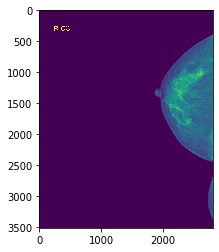

In [84]:
index = 0

path = df_data.loc[index, 'path']
image = read_xray(path, voi_lut=True, fix_monochrome=True)

print(image.shape)

plt.imshow(image)
plt.show()

In [85]:
# resize the image

image1 = resize(image, size=IMAGE_SIZE, keep_ratio=False, resample=Image.LANCZOS)

image1.save('image.png')

!ls

exp06-spine-prepare-the-images-original-size.ipynb
image.png


(512, 512)


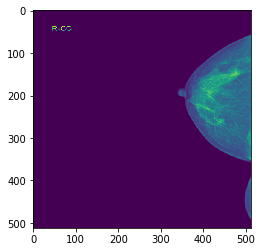

In [87]:
# Load the saved (resized) image

image = plt.imread('image.png')

print(image.shape)

plt.imshow(image)
plt.show()

## Process all the images

In [88]:
# Create the directories

if os.path.isdir('images_dir') == False:

    images_dir = 'images_dir'
    os.mkdir(images_dir)
    

In [89]:
!ls

exp06-spine-prepare-the-images-original-size.ipynb
image.png
images_dir


In [110]:
# Prepare the images

for i in tqdm(range(0, len(df_data)), total=len(df_data)):
    
    # Images
    # -------
    
    # load the image fname
    image_fname = df_data.loc[i, 'image_id']
    
    # add the .png extension
    fname = image_fname + '.png'

    # Load an image
    path = df_data.loc[i, 'path']
    image = read_xray(path, voi_lut=True, fix_monochrome=True)
    
    # 
    #image_size = image.shape[0]
    #print(image_size)
    
    # Don't resize the image
    # This step just enables the code to run. It doesn't change
    # the input image size.
    #image = resize(image, size=image_size, keep_ratio=False, resample=Image.LANCZOS)
    
    # Use this line when we are not resizing
    image = Image.fromarray(image)
    
    # Save the image in the folder
    # that we created.
    dst = os.path.join(images_dir, fname)
    image.save(dst)
    
    
    
    
# Compress the folders so they can appear
# in the notebook output.
# Source: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image

#!tar -zcf images.tar.gz -C "images_dir/" .
#!tar -zcf masks.tar.gz -C "masks_dir/" .

In [101]:
print(len(os.listdir('images_dir')))

42


5a94dd668eaa9865b907450c37db6ecc.png
(3518, 2800)
0.0
1.0


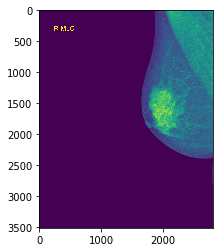

In [107]:
image_list = os.listdir('images_dir')

path = 'images_dir/' + image_list[0]
image = plt.imread(path)

print(image_list[0])

print(image.shape)
print(image.min())
print(image.max())

plt.imshow(image)

plt.show()

In [106]:
# Check that the size matches the size shown in the dataframe

df_data[df_data['image_id'] == '5a94dd668eaa9865b907450c37db6ecc']

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,path,num_findings,target
6,89524e5f372d9aff8ed43b4ef29c1435,0838a0b906894e0cc06c993426a2d143,5a94dd668eaa9865b907450c37db6ecc,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,1988.060059,1793.73999,2139.909912,1967.459961,training,/Volumes/WDExtDrive/Woza-Mammogram-Analyzer/Ra...,1,1


In [108]:
df_data['height'].value_counts()

3518    975
2812    227
3580    224
Name: height, dtype: int64

In [109]:
df_data['width'].value_counts()

2800    975
2012    227
2812    155
2609      8
2706      7
2606      6
2702      5
2718      5
2675      4
2638      4
2654      4
2670      3
2622      2
2657      2
2663      2
2766      2
2782      2
2736      2
2681      2
2686      1
2754      1
2694      1
2798      1
2724      1
2734      1
2750      1
2621      1
2808      1
Name: width, dtype: int64

## Save the dataframe

In [111]:
# Save this dataframe because it shows which images we have prepared

path = 'df_data.csv'
df_data.to_csv(path, index=False)

## Save the image folders

In [25]:
# Compress the folders so they can appear
# in the notebook output.
# Source: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image

#!tar -zcf images.tar.gz -C "images_dir/" .


In [26]:
!ls

__notebook__.ipynb  df_data.csv  image.png  images_dir


In [27]:
# Delete the folders to prevent a Kaggle error.

#if os.path.isdir('images_dir') == True:
    #shutil.rmtree('images_dir')
    